In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
from general_utils import rank_and_bin
from plot_utils import plot_and_compare_results

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

https://www.nature.com/articles/nature21065

"All liver zonation profiles previously described were monotonically increasing or decreasing porto–centrally. Our high spatial resolution enabled identification of a new class of non-monotonic zonation profiles that peak at intermediate lobule layers (Figs. 3c, 4a, Extended Data Figs 5, 10). Although there was no significant gene ontology annotation associated with these genes, they included key liver genes such as Hamp and Hamp2 that encode hepcidin, a secreted liver hormone that regulates systemic iron levels (Fig. 4a). Additional non-monotonic genes included Igfbp2, Mup3 and Cyp8b1 (Fig. 3c, Extended Data Figs 5, 10). The non-monotonic expression of these genes could not be explained by the previously identified non-monotonic pattern of liver polyploidy25 (Extended Data Fig. 10e, Methods)."

### Load the ground-truth and evaluate the methods

In [34]:
logger.setLevel(logging.DEBUG)
from liver_info import load_processsed_hepatocyte_data, load_zonation_result
dat_dir = "/share/PI/sabatti/sc_data/liver2k"
fdir = '/scratch/PI/sabatti/spatial_subplots/'
zone_vals = load_zonation_result(dat_dir, just_vals=True)
main_dir = os.path.join(dat_dir, "analysis_on_data_original")
lm_genes = get_known_liver_markers()["zonation"]
report_genes = ["Hamp", "Hamp2", "Igfbp2", "Mup3", "Cyp8b1"]
x_k, x_d, obs_df, var_df = load_processsed_hepatocyte_data(main_dir, center=False, scale=False)

[feat_viz INFO] Data directory: /share/PI/sabatti/sc_data/liver2k/analysis_on_data_original/data
[feat_viz INFO] Loaded data: x (1415, 6) and y (1415, 8883)


### Load the results prescribed method (ran below)

In [4]:
from io_utils import load_all_pipeline_results
RDIR = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_050719"
pipe_res, all_lams = load_all_pipeline_results(RDIR)
all_lams["smFISH"] = zone_vals
# vanilla: our proposed approach
# oracle: approach using the zones from the original study
# graph: our proposed approach
# pc: the linear PC equivalent approach
# hybrid: using the 1-PC to construct the graph
mopts = ["graph", "pc", "hybrid"]
mtypes = ["vanilla", "oracle"]
for method in mopts:
    for mtype in mtypes:
        key = "{}_{}".format(method, mtype)
        result = pipe_res[key] 
        for lam_t in ["lam_init", "lam_update"]:
            name = "{}_{}".format(key, lam_t)
            all_lams[name] = result[lam_t]
# load additional results
# palantir, paga: trajectory inferece using all genes
# add the other benchmark methods
mdir = '/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/hepa_data/ti_methods'
names = ['palantir', 'paga']
for name in names:
    fn = os.path.join(mdir, '{}_obs_df.csv'.format(name))
    df = pd.read_csv(fn)
    df = df.set_index('cell_id')
    df = df.loc[obs_df.index]
    all_lams[name] = df['pseudotime']                 
lam_df = pd.DataFrame(all_lams)
# manually switch signs for absolute correlation
switch_signs = ["graph_vanilla_lam_init", 
                "graph_vanilla_lam_update",
                "pc_vanilla_lam_update",
                "unsup_pc"]
for var in switch_signs:
    lam_df[var] = - lam_df[var]
    
display(lam_df.head())

unsup_graph  unsup_pc  smFISH  graph_vanilla_lam_init  \
Cell1     0.017049  4.522994       3                0.010613   
Cell2     0.011912 -9.614326       7                0.029973   
Cell3     0.019878 -1.569354       7                0.026740   
Cell4     0.021721  1.490625       7                0.031416   
Cell5     0.013850 -7.101352       4               -0.029628   

       graph_vanilla_lam_update  graph_oracle_lam_init  \
Cell1                  0.022753           0.000000e+00   
Cell2                  0.022153          -9.228443e-18   
Cell3                  0.024046           8.584734e-17   
Cell4                  0.018866          -9.686125e-18   
Cell5                 -0.054783          -1.450494e-17   

       graph_oracle_lam_update  pc_vanilla_lam_init  pc_vanilla_lam_update  \
Cell1                 0.017010            -0.568632               4.772119   
Cell2                 0.021553             1.708969               4.174905   
Cell3                 0.025185             1.278176               5.743204   
Cell4                 0.020967             2.060846               7.690742   
Cell5                -0.044778            -1.024459             -12.230676   

       pc_oracle_lam_init  pc_oracle_lam_update  hybrid_vanilla_lam_init  \
Cell1                   3             -5.690150                -0.568632   
Cell2                   7             -2.988103                 1.708969   
Cell3                   7             -4.696668                 1.278176   
Cell4                   7             -7.256610                 2.060846   
Cell5                   4             12.133470                -1.024459   

       hybrid_vanilla_lam_update  hybrid_oracle_lam_init  \
Cell1                   0.019459                       3   
Cell2                   0.024558                       7   
Cell3                   0.027853                       7   
Cell4                   0.023694                       7   
Cell5                  -0.038515                       4   

       hybrid_oracle_lam_update  palantir      paga  
Cell1                  0.017010  0.682967  0.600050  
Cell2                  0.021553  0.768242  0.621814  
Cell3                  0.025185  0.781591  0.678568  
Cell4                  0.020967  0.768702  0.654502  
Cell5                 -0.044778  0.137123  0.229735

### Plot pairwise correlations with lambdas of interest

$\pi^\mathtt{B}$  $\pi^\mathtt{G}$  $\xi^\mathtt{G}$  \
Cell1                 3          0.010613          0.022753   
Cell2                 7          0.029973          0.022153   
Cell3                 7          0.026740          0.024046   
Cell4                 7          0.031416          0.018866   
Cell5                 4         -0.029628         -0.054783   

       $\omega^\mathtt{1}$  $\omega^\mathtt{2}$  
Cell1             0.682967             0.600050  
Cell2             0.768242             0.621814  
Cell3             0.781591             0.678568  
Cell4             0.768702             0.654502  
Cell5             0.137123             0.229735

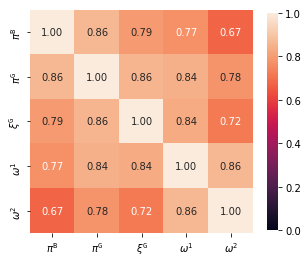

In [5]:
from plot_utils import plot_corr_mtx

# select and rename here
select_vars = {
    "smFISH": r"$\pi^\mathtt{B}$",
    "graph_vanilla_lam_init": r"$\pi^\mathtt{G}$",
#     "pc_vanilla_lam_init": r"$\pi^\mathtt{P}$",
    "graph_vanilla_lam_update": r"$\xi^\mathtt{G}$",
#     "pc_vanilla_lam_update": r"$\xi^\mathtt{P}$",
#     "unsup_graph": r"$\omega^\mathtt{G}$",
#     "unsup_pc": r"$\omega^\mathtt{P}$",
    "palantir": r"$\omega^\mathtt{1}$",
    "paga" : r"$\omega^\mathtt{2}$"
}
sub_df = lam_df[list(select_vars.keys())]
sub_df = sub_df.rename(index=str, columns=select_vars)
display(sub_df.head())
# save the lambdas to file
# sub_df.to_csv("~/lambdas.csv", index=False)
# fn = '/scratch/users/jjzhu/tmp_fig/hepa_hm.pdf'
fn = None
plot_corr_mtx(sub_df, fn=fn)

### Customized Figure

[feat_viz INFO] Saved figure to: /scratch/PI/sabatti/spatial_subplots/hepa_lambda_heatmap.pdf


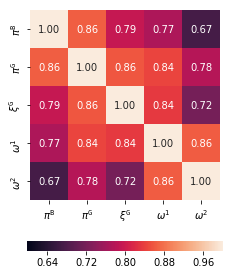

In [14]:
fn = fdir + 'hepa_lambda_heatmap.pdf'
show_cbar = True
vmin=0.6
vmax=1
corr_df = sub_df.corr('spearman')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr_df, annot=True, fmt=".2f", square=True, ax=ax,
                cbar=show_cbar, vmin=vmin, vmax=vmax,
                cbar_kws = dict(shrink=0.7,use_gridspec=False,location="bottom"))
plt.savefig(fn, bbox_inches='tight', transparent=True) 
logger.info("Saved figure to: {}".format(fn))
plt.show()

### Search for p-values of known genes

In [71]:
from main_methods import setup_cmp_df
from liver_info import get_known_liver_markers, get_marker_color_dict
from plot_utils import create_color_map, plot_full_pattern
from matplotlib.ticker import FormatStrFormatter
from plot_utils import update_boxplot_cols

def get_unique_rejection_df(res_dict, var_df):
    pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(res_dict)
    pval_df = pd.concat([var_df.reset_index(drop=True), pval_df], axis=1)
    df_list = []
    for i in range(2):
        j = 1 * (i == 0)
        sub_df = pval_df.loc[pval_df[mets[i]] <= pval_thres[i]]
        sub_df = sub_df.loc[sub_df[mets[j]] > pval_thres[j]]
        sub_df["exclusive_rejection"] = mets[i]
        logger.info("Set selection: {}".format(sub_df.shape)) 
        sub_df = sub_df.set_index("gene_ids")
        sub_df = sub_df.sort_values([mets[i], mets[j]], ascending=[1, 0])
#         sub_df = sub_df.sort_values([mets[i], "std"], ascending=[1, 0])
        df_list.append(sub_df)
    df_comp = pd.concat(df_list, axis=0) # should never conflict
    df_dict = dict(zip(mets, df_list))
    return df_dict, df_comp

def parse_exlusive_genes():
    mets = list(res_dict.keys())
    use_lam = (lam_in is not None)
    for i in range(2):
        j = 1 * (i == 0)
        sub_df = df_comp.sort_values([mets[i], mets[j]], ascending=[1, 0])
        sub_df = sub_df.head(disp_genes)
        display(sub_df)
        plt_idx = list(sub_df.index)
        plt_genes = list(sub_df.loc[plt_idx]["gene_ids"])
        if not use_lam:
            lam_in = res_dict[mets[i]]["lam_init"]
        if cat_avg:
            lam_in = rank_and_bin(lam_in, n_bins=9)                
        plot_gene_profile(lam_in, x_d[:, plt_idx], plt_genes, cat_avg=cat_avg)
        
def report_gene_info(report_genes, unique_df):
    for gene in report_genes:
        if gene in unique_df.index:
            gene_info = unique_df.loc[gene]
            logger.info("{} only rejected by {}".format(gene, gene_info["exclusive_rejection"]))
    display(pval_df[pval_df["gene_ids"].isin(report_genes)])
    

def plot_gene_expr_comp(lam_df, x_d, genes, methods, horizontal=False, fn=None):
    fontsize=23
    labels = list(lam_df["smFISH"])
    if len(genes) == 1 and len(methods) == 1:
        fig, axes = plt.subplots(1, 1, figsize=(5, 4))
    else:
        if horizontal:
            fig, axes = plt.subplots(len(methods), len(genes), 
                                 figsize=(2.3*len(genes), 2*len(methods)))
        else:
            fig, axes = plt.subplots(len(genes), len(methods), 
                                 figsize=(1.85*len(methods),1.9*len(genes)),
                                 sharex="col", sharey="row")
    
    for i, gene in enumerate(genes):
        gid = var_df.index.get_loc(gene)
        for j, method in enumerate(methods):
            if len(genes) == 1 and len(methods) == 1:
                ax = axes
                add_cbar = True
            else:
                add_cbar = False
                if len(genes) == 1:
                    ax = axes[j]
                elif len(methods) == 1:
                    ax = axes[i]
                else:        
                    if horizontal:
                        ax = axes[j, i]
                    else:
                        ax = axes[i, j]
            order_only = (method != "smFISH")
            plot_full_pattern(ax, lam_df[method], x_d[:,gid], 
                              order_only=order_only,
                              add_color_bar=add_cbar, labels=labels)    
            if horizontal:
                ax.set_xlabel(None)
                fig.subplots_adjust(hspace=0.5, wspace=0.42)
                ax.set_ylabel(gene, labelpad=0, fontsize=fontsize)
                if len(methods) > 1:
                    ax.set_title(select_vars[method])    
            else:
                if j == 0:
                    ax.set_ylabel(gene, fontsize=fontsize,  style='italic')
                if i == (len(genes) -1):
                    ax.set_xlabel(select_vars[method], fontsize=fontsize)
                fig.subplots_adjust(hspace=0, wspace=0)
            
            ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.tick_params(axis='both', which='major', pad=2, labelsize=fontsize-5)
            if method == "smFISH":
                xticks = [1,3, 5, 7, 9]
            else:
                xticks = [0, 1000]
            if gene == "Malat1":
                ax.set_ylim(-0.5, 3)
                ax.set_yticks(ticks=[0, 1, 2])  
            ax.set_xticks(ticks=xticks)    
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True, dpi=100) 
        logger.info("Saved figure to: {}".format(fn))
    plt.show()
    

def contrast_methods_gene(res_dict, var_df, x_d, lam_in=None, disp_genes=8):
    pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(res_dict)
    var_df = var_df.reset_index(drop=True)
    pval_df = pd.concat([var_df, pval_df], axis=1)
    logger.info("Merged df: {}".format(pval_df.shape))    
    union_idx = set.union(*cmp_sets)
    df_comp = get_unique_rejection_df(res_dict, var_df)
    use_lam = (lam_in is not None)
    for i in range(2):
        j = 1 * (i == 0)
        sub_df = df_comp.sort_values([mets[i], mets[j]], ascending=[1, 0])
        sub_df = sub_df.head(disp_genes)
        display(sub_df)
        plt_idx = list(sub_df.index)
        fig, axes = plt.subplots(1, len(plt_idx), figsize=(len(plt_idx)*3, 3))
        if not use_lam:
            lam_in = res_dict[mets[i]]["lam_init"]
        for i_g, g_idx in enumerate(plt_idx):
            ax = axes[i_g]
            ax.scatter(lam_in, x_d[:, g_idx], s=5)
            ax.set_title(sub_df.loc[g_idx]["gene_ids"])
        plt.show()
        
def plot_contrast_rejections(res_dict, var_df, plain=False, fn=None):
    fontsize=15
    my_pal = {"pc_vanilla": "red", "graph_vanilla":"blue"}
    _, df_comp = get_unique_rejection_df(res_dict, var_df)
    plt_vars = ['sparsity', 'cv']
    fig, axes = plt.subplots(1, len(plt_vars), figsize=(len(plt_vars)*2.7, 3))
    for i_plt, var in enumerate(plt_vars):
        ax = axes[i_plt]
        

        sns.boxplot(x="exclusive_rejection", y=var, 
                    data=df_comp, ax=ax, 
#                     order=["graph_vanilla", "pc_vanilla"],
                    palette="Set1",
                    width=0.5, fliersize=1)
        ax.set_title(var)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        update_boxplot_cols(ax)
        if plain:
            ax.set_title(None)
            ax.set_xticks([])
            ax.tick_params(axis='both', which='major', pad=2, labelsize=fontsize)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        logger.info("Saved figure to: {}".format(fn))
    plt.show()

In [31]:
var_df.head()

gene_ids  n_cells      mean       std  npc  \
0610007C21Rik;Apr3      0610007C21Rik;Apr3      770  0.487967  0.527124  770   
0610007L01Rik                0610007L01Rik      761  0.455494  0.506628  761   
0610007P08Rik;Rad26l  0610007P08Rik;Rad26l       65  0.030682  0.159816   65   
0610007P14Rik                0610007P14Rik      749  0.456374  0.518156  749   
0610007P22Rik                0610007P22Rik       35  0.015438  0.107326   35   

                         pvals  rejects  
0610007C21Rik;Apr3    0.025097    False  
0610007L01Rik         0.104790    False  
0610007P08Rik;Rad26l  0.307769    False  
0610007P14Rik         0.015298    False  
0610007P22Rik         0.899710    False

In [38]:
key = 'graph_vanilla'
var_df['pvals'] = pipe_res[key]['p_vals']
rej_vec = np.repeat(False, var_df.shape[0])
rej_vec[pipe_res[key]['rejections']] = True
var_df['rejects'] = rej_vec

In [42]:
print('Number of SV genes: {}'.format(len(pipe_res[key]['rejections'])))
display(var_df.loc[lm_genes])
display(var_df.loc[report_genes])

Number of SV genes: 1483


gene_ids  n_cells      mean       std   npc   pvals  rejects
Cyp2e1   Cyp2e1     1221  3.086100  2.132811  1221  0.0001     True
Cyp2f2   Cyp2f2     1235  2.269190  1.415569  1235  0.0001     True
Alb         Alb     1415  6.190163  0.610225  1415  0.0001     True
Ass1       Ass1     1411  3.164296  0.588850  1411  0.0001     True
Asl         Asl     1397  2.707551  0.570133  1397  0.0001     True
Glul       Glul      523  0.347392  0.661617   523  0.0001     True

gene_ids  n_cells      mean       std   npc   pvals  rejects
Hamp       Hamp     1327  2.937353  1.240587  1327  0.0001     True
Hamp2     Hamp2     1158  1.595090  1.069451  1158  0.0001     True
Igfbp2   Igfbp2     1257  1.622701  0.830093  1257  0.0001     True
Mup3       Mup3     1366  2.975959  1.237950  1366  0.0001     True
Cyp8b1   Cyp8b1     1315  1.913578  0.753823  1315  0.0001     True

[feat_viz INFO] Saved figure to: /scratch/PI/sabatti/spatial_subplots/hepa_scatter_lm_genes.png


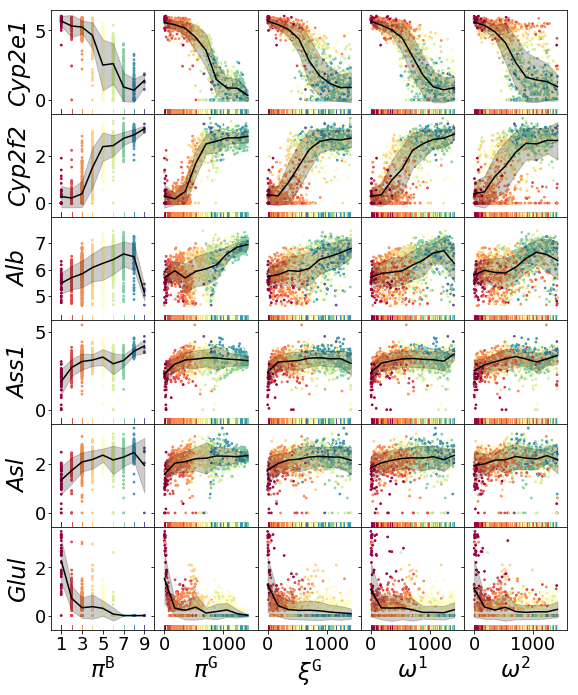

In [72]:
fn = fdir + 'hepa_scatter_lm_genes.png'
plot_gene_expr_comp(lam_df, x_d, lm_genes, methods, fn=fn)

[feat_viz INFO] Saved figure to: /scratch/PI/sabatti/spatial_subplots/hepa_scatter_report_genes.png


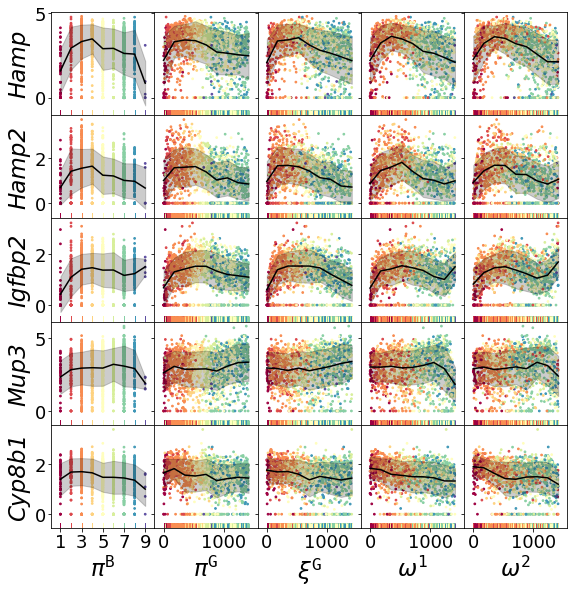

In [73]:
fn = fdir + 'hepa_scatter_report_genes.png'
plot_gene_expr_comp(lam_df, x_d, report_genes, methods, fn=fn)

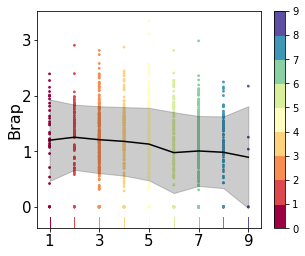

In [41]:
# example of a single gene and a single method
plot_gene_expr_comp(lam_df, x_d, ["Brap"], ["smFISH"], horizontal=True)

## Comparison with PCA-based approach

In [19]:
methods = ["smFISH",
           "graph_vanilla_lam_init", 
           "graph_vanilla_lam_update", 
           "palantir",
           "paga"]
# methods = ["smFISH", 
#            "graph_vanilla_lam_init", 
#            "pc_vanilla_lam_init", 
#            "graph_vanilla_lam_update", 
#            "pc_vanilla_lam_update",
#            "unsup_graph",
#            "unsup_pc"]


cmp_methods = {key: pipe_res[key] for key in ["pc_vanilla", "graph_vanilla"]}
pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(cmp_methods)
pval_df = pd.concat([var_df.reset_index(drop=True), pval_df], axis=1)
pval_df.head()
lm_genes = get_known_liver_markers()["zonation"]
report_genes = ["Hamp", "Hamp2", "Igfbp2", "Mup3", "Cyp8b1"]
unique_dict, unique_df = get_unique_rejection_df(cmp_methods, var_df)
unique_glist = {}
top_k = 10
for key in cmp_methods:
    unique_glist[key] = list(unique_dict[key].index[:top_k])
    display(unique_dict[key].head(top_k))
display(unique_df.head())

# plot box plots
var_df["cv"] = var_df["std"] / var_df["mean"]
var_df["sparsity"] = 1 - (var_df["n_cells"]/ x_d.shape[0])
display(var_df.head())
plot_contrast_rejections(cmp_methods, var_df)


plot_gene_expr_comp(lam_df, x_d, lm_genes, methods)

NameError: name 'unique_df' is not defined

[feat_viz INFO] Igfbp2 only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc  pc_vanilla  graph_vanilla
2371   Cyp8b1     1315  1.913578  0.753823  1315    0.000100         0.0001
3764     Hamp     1327  2.937353  1.240587  1327    0.000500         0.0001
3765    Hamp2     1158  1.595090  1.069451  1158    0.000100         0.0001
4044   Igfbp2     1257  1.622701  0.830093  1257    0.033297         0.0001
5043     Mup3     1366  2.975959  1.237950  1366    0.000100         0.0001

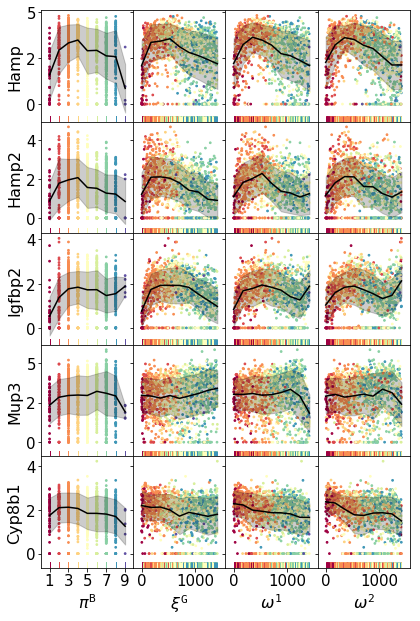

In [19]:
plot_gene_expr_comp(lam_df, x_d, report_genes, methods)

[feat_viz INFO] Phf3 only rejected by pc_vanilla
[feat_viz INFO] Pias4;PIAS-gamma only rejected by pc_vanilla
[feat_viz INFO] Serpine2 only rejected by pc_vanilla
[feat_viz INFO] Mylk;Mlyk only rejected by pc_vanilla
[feat_viz INFO] Acyp1 only rejected by pc_vanilla
[feat_viz INFO] Dnaja4 only rejected by pc_vanilla
[feat_viz INFO] Snhg6 only rejected by pc_vanilla
[feat_viz INFO] Aldh1a7 only rejected by pc_vanilla


gene_ids  n_cells      mean       std  npc  pc_vanilla  \
781              Acyp1      371  0.187429  0.366070  371      0.0001   
908            Aldh1a7      716  0.439747  0.516800  716      0.0001   
2627            Dnaja4       55  0.021674  0.119090   55      0.0001   
5072         Mylk;Mlyk      426  0.226912  0.418408  426      0.0001   
5761              Phf3      582  0.331940  0.470883  582      0.0001   
5785  Pias4;PIAS-gamma      174  0.090250  0.276415  174      0.0001   
6967          Serpine2      189  0.096100  0.278162  189      0.0001   
7296             Snhg6      616  0.353233  0.471623  616      0.0001   

      graph_vanilla  
781        0.412859  
908        0.337766  
2627       0.401760  
5072       0.598340  
5761       0.838516  
5785       0.692231  
6967       0.623338  
7296       0.338466

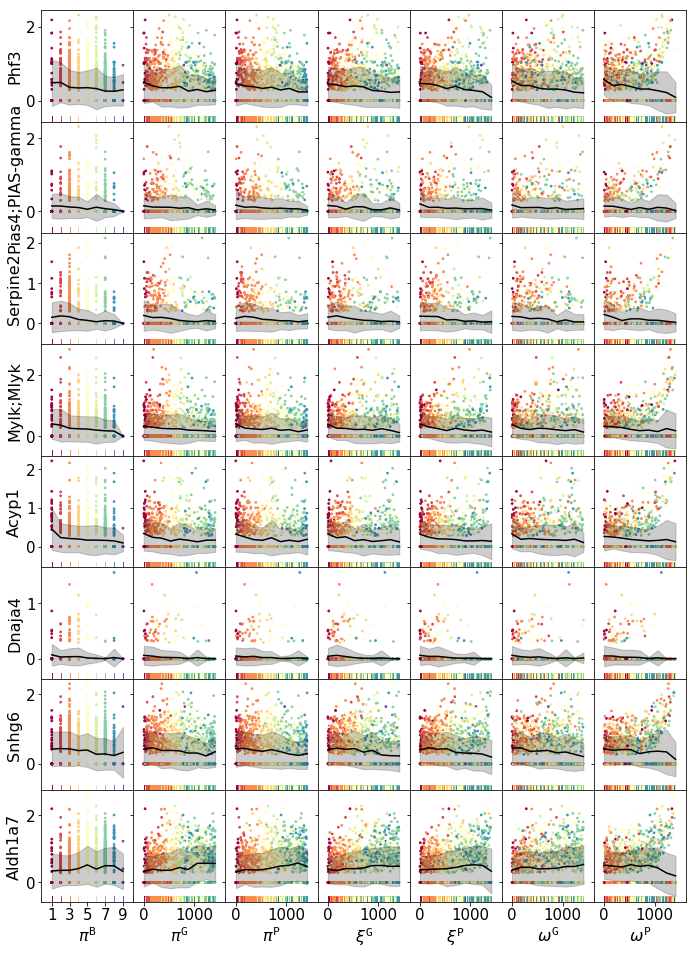

In [23]:
plot_gene_expr_comp(lam_df, x_d, unique_glist["pc_vanilla"][:8], methods)

[feat_viz INFO] Fgl1 only rejected by graph_vanilla
[feat_viz INFO] Ttpa only rejected by graph_vanilla
[feat_viz INFO] Mat1a only rejected by graph_vanilla
[feat_viz INFO] Ces1e only rejected by graph_vanilla
[feat_viz INFO] Ptplad1 only rejected by graph_vanilla
[feat_viz INFO] Hist1h1b only rejected by graph_vanilla
[feat_viz INFO] Aplp2 only rejected by graph_vanilla
[feat_viz INFO] C4bp only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc  pc_vanilla  graph_vanilla
1045     Aplp2     1154  1.118560  0.676803  1154    0.866513         0.0001
1604      C4bp      858  0.712044  0.701095   858    0.861914         0.0001
1915     Ces1e     1005  0.789574  0.623091  1005    0.902010         0.0001
3252      Fgl1     1180  1.262376  0.716935  1180    0.985501         0.0001
3855  Hist1h1b       29  0.021064  0.164727    29    0.867813         0.0001
4653     Mat1a     1414  3.928493  0.370627  1414    0.914909         0.0001
6238   Ptplad1      656  0.384490  0.491875   656    0.868713         0.0001
8138      Ttpa      607  0.350444  0.494714   607    0.917508         0.0001

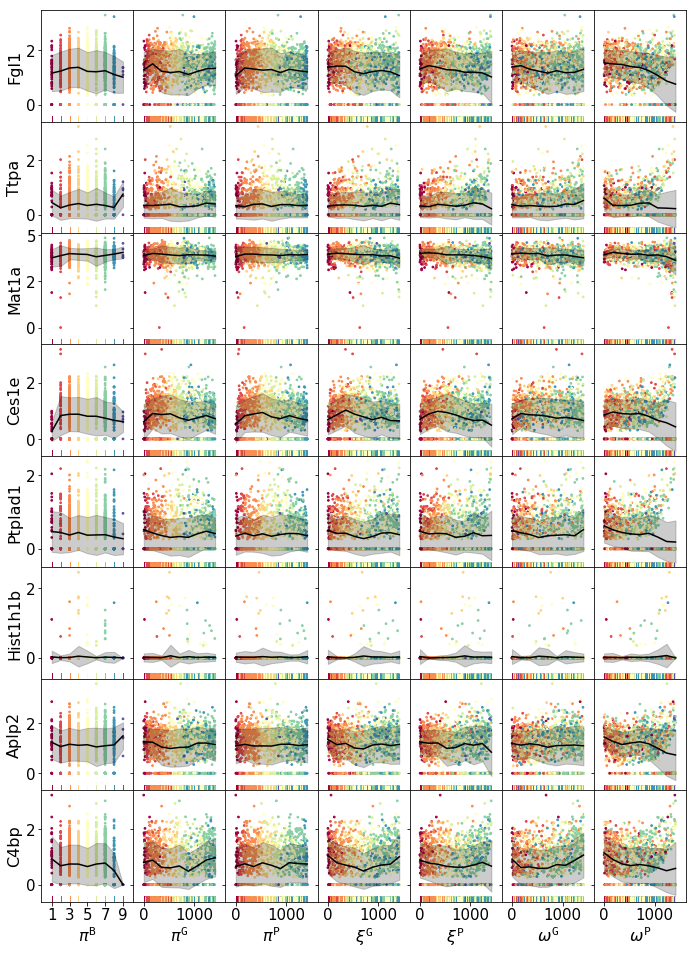

In [24]:
plot_gene_expr_comp(lam_df, x_d, unique_glist["graph_vanilla"][:8], methods)

## Save figures to file

In [38]:
FDIR = "/share/PI/sabatti/feat_viz/main_figs"

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_heatmap.pdf


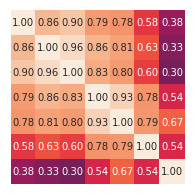

In [39]:
fn = os.path.join(FDIR, "real_data_heatmap.pdf")
plot_corr_mtx(sub_df, plain=True, fn=fn)

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] Set selection: (793, 10)
[feat_viz INFO] Set selection: (661, 10)
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_box_uniq.pdf


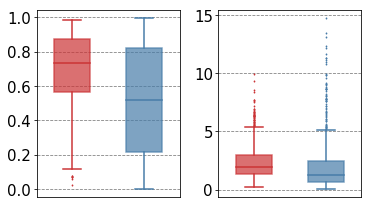

In [47]:
fn = os.path.join(FDIR, "real_data_box_uniq.pdf")
plot_contrast_rejections(cmp_methods, var_df, plain=True, fn=fn)

[feat_viz INFO] Brap only rejected by pc_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
1525     Brap     1189  1.103937  0.646323  1189  0.585471  0.159717   

      pc_vanilla  graph_vanilla  
1525      0.0001       0.018298

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_scalebar.pdf


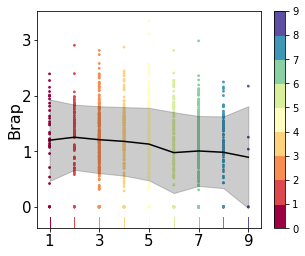

gene_ids  n_cells      mean       std   npc        cv  sparsity  \
904       Alb     1415  6.190163  0.610225  1415  0.098580  0.000000   
1191      Asl     1397  2.707551  0.570133  1397  0.210571  0.012721   
1200     Ass1     1411  3.164296  0.588850  1411  0.186092  0.002827   
2350   Cyp2e1     1221  3.086100  2.132811  1221  0.691102  0.137102   
2351   Cyp2f2     1235  2.269190  1.415569  1235  0.623821  0.127208   
3496     Glul      523  0.347392  0.661617   523  1.904525  0.630389   

      pc_vanilla  graph_vanilla  
904       0.0001         0.0001  
1191      0.0001         0.0001  
1200      0.0001         0.0001  
2350      0.0001         0.0001  
2351      0.0001         0.0001  
3496      0.0001         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_lm.pdf


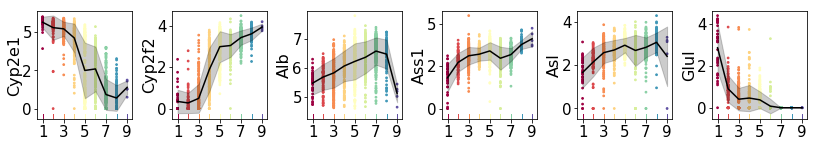

[feat_viz INFO] Igfbp2 only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
3765    Hamp2     1158  1.595090  1.069451  1158  0.670465  0.181625   
4044   Igfbp2     1257  1.622701  0.830093  1257  0.511550  0.111661   

      pc_vanilla  graph_vanilla  
3765    0.000100         0.0001  
4044    0.033297         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_val.pdf


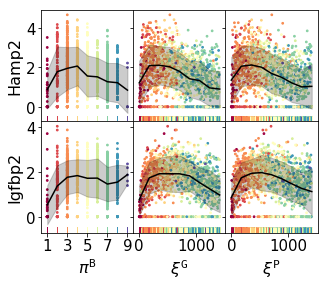

[feat_viz INFO] C4bp only rejected by graph_vanilla
[feat_viz INFO] Phf3 only rejected by pc_vanilla


gene_ids  n_cells      mean       std  npc        cv  sparsity  \
1604     C4bp      858  0.712044  0.701095  858  0.984623  0.393640   
5761     Phf3      582  0.331940  0.470883  582  1.418580  0.588693   

      pc_vanilla  graph_vanilla  
1604    0.861914       0.000100  
5761    0.000100       0.838516

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_uniq.pdf


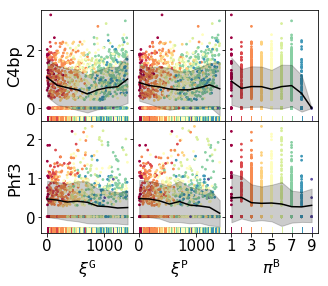

In [49]:
fn = os.path.join(FDIR, "real_data_scalebar.pdf")
plot_gene_expr_comp(lam_df, x_d, ["Brap"], ["smFISH"], horizontal=True, fn=fn)
fn = os.path.join(FDIR, "real_data_genes_lm.pdf")
plot_gene_expr_comp(lam_df, x_d, lm_genes, ["smFISH"], horizontal=True, fn=fn)
fn = os.path.join(FDIR, "real_data_genes_val.pdf")
plot_gene_expr_comp(lam_df, x_d, ["Hamp2", "Igfbp2"], ["smFISH", "graph_vanilla_lam_update", "pc_vanilla_lam_update"], fn=fn)
fn = os.path.join(FDIR, "real_data_genes_uniq.pdf")
plot_gene_expr_comp(lam_df, x_d, ["C4bp", "Phf3"], ["graph_vanilla_lam_update", "pc_vanilla_lam_update","smFISH"],fn=fn)

gene_ids  n_cells      mean       std   npc        cv  sparsity  \
904       Alb     1415  6.190163  0.610225  1415  0.098580  0.000000   
1191      Asl     1397  2.707551  0.570133  1397  0.210571  0.012721   
1200     Ass1     1411  3.164296  0.588850  1411  0.186092  0.002827   
2350   Cyp2e1     1221  3.086100  2.132811  1221  0.691102  0.137102   
2351   Cyp2f2     1235  2.269190  1.415569  1235  0.623821  0.127208   
3496     Glul      523  0.347392  0.661617   523  1.904525  0.630389   

      pc_vanilla  graph_vanilla  
904       0.0001         0.0001  
1191      0.0001         0.0001  
1200      0.0001         0.0001  
2350      0.0001         0.0001  
2351      0.0001         0.0001  
3496      0.0001         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_lm.png


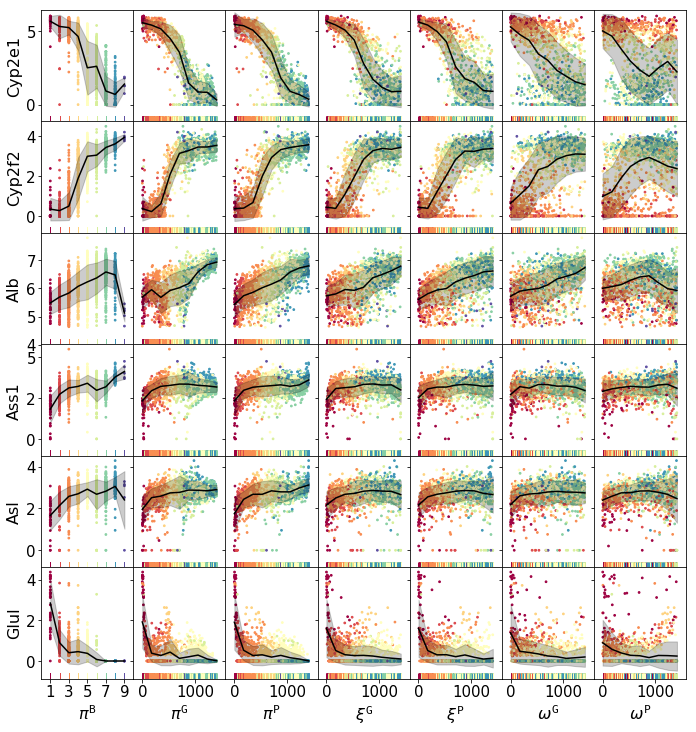

In [43]:
plt_id = "lm"
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, lm_genes, methods, fn=fn)

[feat_viz INFO] Igfbp2 only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
2371   Cyp8b1     1315  1.913578  0.753823  1315  0.393934  0.070671   
3764     Hamp     1327  2.937353  1.240587  1327  0.422349  0.062191   
3765    Hamp2     1158  1.595090  1.069451  1158  0.670465  0.181625   
4044   Igfbp2     1257  1.622701  0.830093  1257  0.511550  0.111661   
5043     Mup3     1366  2.975959  1.237950  1366  0.415984  0.034629   

      pc_vanilla  graph_vanilla  
2371    0.000100         0.0001  
3764    0.000500         0.0001  
3765    0.000100         0.0001  
4044    0.033297         0.0001  
5043    0.000100         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_report.png


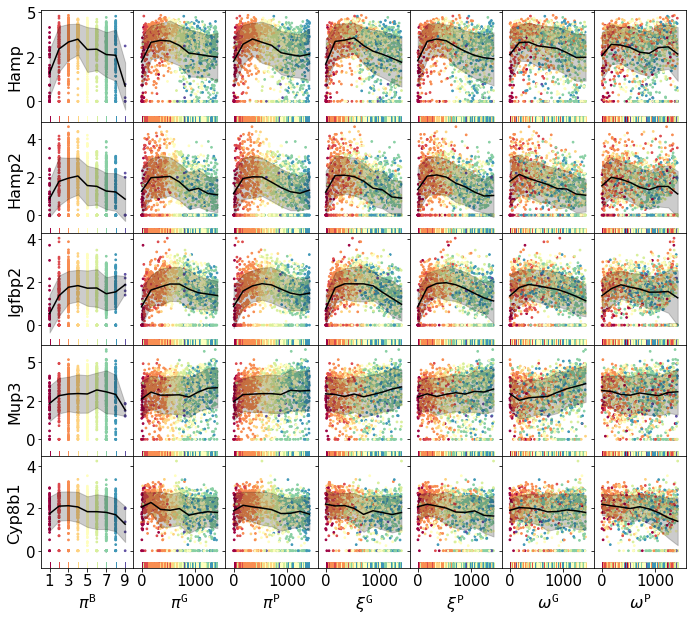

In [44]:
plt_id = "report"
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, report_genes, methods, fn=fn)

[feat_viz INFO] Fgl1 only rejected by graph_vanilla
[feat_viz INFO] Ttpa only rejected by graph_vanilla
[feat_viz INFO] Mat1a only rejected by graph_vanilla
[feat_viz INFO] Ces1e only rejected by graph_vanilla
[feat_viz INFO] Ptplad1 only rejected by graph_vanilla
[feat_viz INFO] Hist1h1b only rejected by graph_vanilla
[feat_viz INFO] Aplp2 only rejected by graph_vanilla
[feat_viz INFO] C4bp only rejected by graph_vanilla


['Fgl1', 'Ttpa', 'Mat1a', 'Ces1e', 'Ptplad1', 'Hist1h1b', 'Aplp2', 'C4bp']


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
1045     Aplp2     1154  1.118560  0.676803  1154  0.605067  0.184452   
1604      C4bp      858  0.712044  0.701095   858  0.984623  0.393640   
1915     Ces1e     1005  0.789574  0.623091  1005  0.789148  0.289753   
3252      Fgl1     1180  1.262376  0.716935  1180  0.567925  0.166078   
3855  Hist1h1b       29  0.021064  0.164727    29  7.820231  0.979505   
4653     Mat1a     1414  3.928493  0.370627  1414  0.094343  0.000707   
6238   Ptplad1      656  0.384490  0.491875   656  1.279292  0.536396   
8138      Ttpa      607  0.350444  0.494714   607  1.411676  0.571025   

      pc_vanilla  graph_vanilla  
1045    0.866513         0.0001  
1604    0.861914         0.0001  
1915    0.902010         0.0001  
3252    0.985501         0.0001  
3855    0.867813         0.0001  
4653    0.914909         0.0001  
6238    0.868713         0.0001  
8138    0.917508         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_graph.png


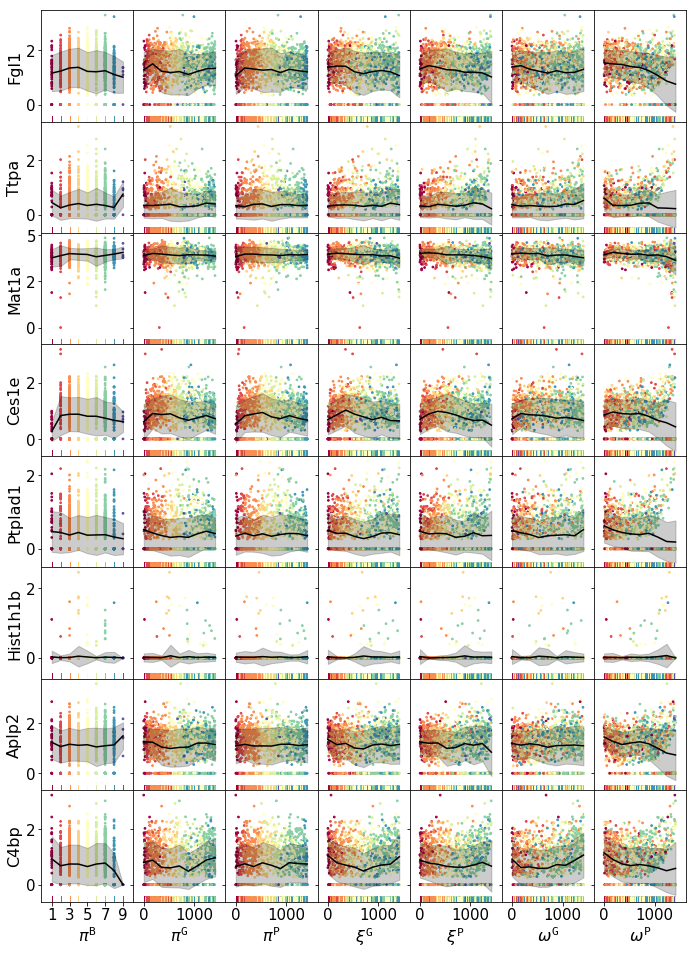

In [45]:
plt_id = "graph"
genes = unique_glist["graph_vanilla"][:8]
print(genes)
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, genes, methods, fn=fn)

[feat_viz INFO] Phf3 only rejected by pc_vanilla
[feat_viz INFO] Pias4;PIAS-gamma only rejected by pc_vanilla
[feat_viz INFO] Serpine2 only rejected by pc_vanilla
[feat_viz INFO] Mylk;Mlyk only rejected by pc_vanilla
[feat_viz INFO] Acyp1 only rejected by pc_vanilla
[feat_viz INFO] Dnaja4 only rejected by pc_vanilla
[feat_viz INFO] Snhg6 only rejected by pc_vanilla
[feat_viz INFO] Aldh1a7 only rejected by pc_vanilla


['Phf3', 'Pias4;PIAS-gamma', 'Serpine2', 'Mylk;Mlyk', 'Acyp1', 'Dnaja4', 'Snhg6', 'Aldh1a7']


gene_ids  n_cells      mean       std  npc        cv  sparsity  \
781              Acyp1      371  0.187429  0.366070  371  1.953116  0.737809   
908            Aldh1a7      716  0.439747  0.516800  716  1.175222  0.493993   
2627            Dnaja4       55  0.021674  0.119090   55  5.494523  0.961131   
5072         Mylk;Mlyk      426  0.226912  0.418408  426  1.843921  0.698940   
5761              Phf3      582  0.331940  0.470883  582  1.418580  0.588693   
5785  Pias4;PIAS-gamma      174  0.090250  0.276415  174  3.062762  0.877032   
6967          Serpine2      189  0.096100  0.278162  189  2.894513  0.866431   
7296             Snhg6      616  0.353233  0.471623  616  1.335159  0.564664   

      pc_vanilla  graph_vanilla  
781       0.0001       0.412859  
908       0.0001       0.337766  
2627      0.0001       0.401760  
5072      0.0001       0.598340  
5761      0.0001       0.838516  
5785      0.0001       0.692231  
6967      0.0001       0.623338  
7296      0.0001       0.338466

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_pca.png


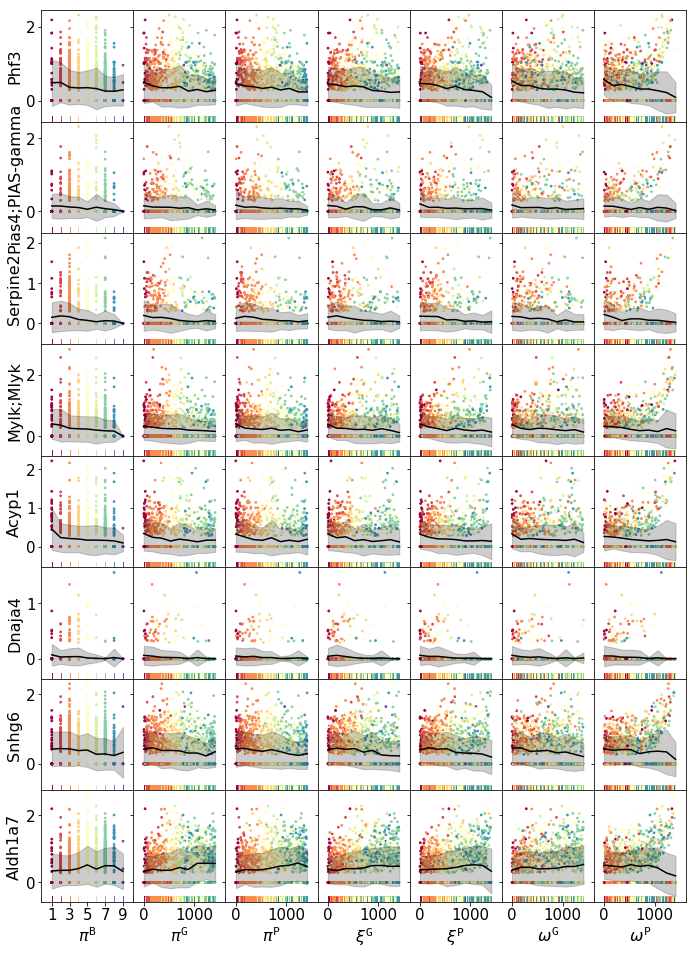

In [46]:
plt_id = "pca"
genes = unique_glist["pc_vanilla"][:8]
print(genes)
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, genes, methods, fn=fn)

# Comparison with PC methods

### Run all the prescribed methods and save to file

In [5]:
def compare_methods(res, mlist):
    cmp_methods = {}
    for m in mlist:
        assert m in res, "{} not found".format(m)
        cmp_methods[m] = res[m]
    plot_and_compare_results(cmp_methods)

dict_keys(['pc_vanilla', 'pc_oracle', 'graph_vanilla', 'graph_oracle', 'hybrid_vanilla', 'hybrid_oracle'])

dict_keys(['unsup_graph', 'unsup_pc'])

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] pc_oracle threshold: 0.0097


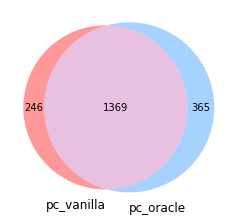

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083


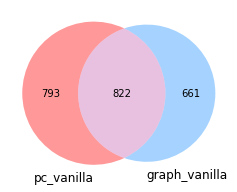

[feat_viz INFO] hybrid_vanilla threshold: 0.0014
[feat_viz INFO] graph_vanilla threshold: 0.0083


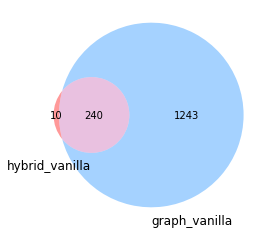

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] hybrid_vanilla threshold: 0.0014


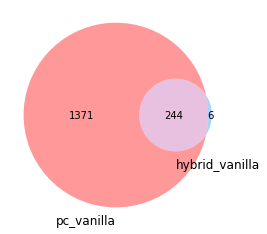

In [6]:
pipe_res, all_lams = load_all_pipeline_results(RDIR)
display(pipe_res.keys())
display(all_lams.keys())

compare_methods(pipe_res, ["pc_vanilla", "pc_oracle"])
compare_methods(pipe_res, ["pc_vanilla", "graph_vanilla"])
compare_methods(pipe_res, ["hybrid_vanilla", "graph_vanilla"])
compare_methods(pipe_res, ["pc_vanilla", "hybrid_vanilla"])

[feat_viz INFO] Saved figure to: /scratch/users/jjzhu/tmp_fig/hepa_hm.pdf


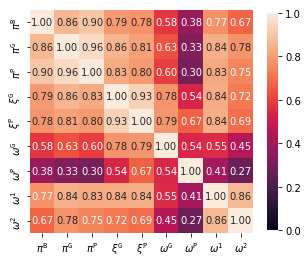

In [10]:
# previous comparisons

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] Set selection: (793, 8)
[feat_viz INFO] Set selection: (661, 8)


n_cells      mean       std  npc  pc_vanilla  graph_vanilla  \
gene_ids                                                                        
Phf3                  582  0.331940  0.470883  582      0.0001       0.838516   
Pias4;PIAS-gamma      174  0.090250  0.276415  174      0.0001       0.692231   
Serpine2              189  0.096100  0.278162  189      0.0001       0.623338   
Mylk;Mlyk             426  0.226912  0.418408  426      0.0001       0.598340   
Acyp1                 371  0.187429  0.366070  371      0.0001       0.412859   
Dnaja4                 55  0.021674  0.119090   55      0.0001       0.401760   
Snhg6                 616  0.353233  0.471623  616      0.0001       0.338466   
Aldh1a7               716  0.439747  0.516800  716      0.0001       0.337766   
Chkb                  572  0.327438  0.473519  572      0.0001       0.300770   
Cela1                 399  0.205881  0.381610  399      0.0001       0.300670   

                 exclusive_rejection  
gene_ids                              
Phf3                      pc_vanilla  
Pias4;PIAS-gamma          pc_vanilla  
Serpine2                  pc_vanilla  
Mylk;Mlyk                 pc_vanilla  
Acyp1                     pc_vanilla  
Dnaja4                    pc_vanilla  
Snhg6                     pc_vanilla  
Aldh1a7                   pc_vanilla  
Chkb                      pc_vanilla  
Cela1                     pc_vanilla

n_cells      mean       std   npc  pc_vanilla  graph_vanilla  \
gene_ids                                                                 
Fgl1         1180  1.262376  0.716935  1180    0.985501         0.0001   
Ttpa          607  0.350444  0.494714   607    0.917508         0.0001   
Mat1a        1414  3.928493  0.370627  1414    0.914909         0.0001   
Ces1e        1005  0.789574  0.623091  1005    0.902010         0.0001   
Ptplad1       656  0.384490  0.491875   656    0.868713         0.0001   
Hist1h1b       29  0.021064  0.164727    29    0.867813         0.0001   
Aplp2        1154  1.118560  0.676803  1154    0.866513         0.0001   
C4bp          858  0.712044  0.701095   858    0.861914         0.0001   
Lpgat1       1043  0.821111  0.625455  1043    0.845015         0.0001   
Atp5e        1361  1.968188  0.639012  1361    0.822418         0.0001   

         exclusive_rejection  
gene_ids                      
Fgl1           graph_vanilla  
Ttpa           graph_vanilla  
Mat1a          graph_vanilla  
Ces1e          graph_vanilla  
Ptplad1        graph_vanilla  
Hist1h1b       graph_vanilla  
Aplp2          graph_vanilla  
C4bp           graph_vanilla  
Lpgat1         graph_vanilla  
Atp5e          graph_vanilla

n_cells      mean       std  npc  pc_vanilla  graph_vanilla  \
gene_ids                                                                        
Phf3                  582  0.331940  0.470883  582      0.0001       0.838516   
Pias4;PIAS-gamma      174  0.090250  0.276415  174      0.0001       0.692231   
Serpine2              189  0.096100  0.278162  189      0.0001       0.623338   
Mylk;Mlyk             426  0.226912  0.418408  426      0.0001       0.598340   
Acyp1                 371  0.187429  0.366070  371      0.0001       0.412859   

                 exclusive_rejection  
gene_ids                              
Phf3                      pc_vanilla  
Pias4;PIAS-gamma          pc_vanilla  
Serpine2                  pc_vanilla  
Mylk;Mlyk                 pc_vanilla  
Acyp1                     pc_vanilla

gene_ids  n_cells      mean       std  npc  \
0610007C21Rik;Apr3      0610007C21Rik;Apr3      770  0.487967  0.527124  770   
0610007L01Rik                0610007L01Rik      761  0.455494  0.506628  761   
0610007P08Rik;Rad26l  0610007P08Rik;Rad26l       65  0.030682  0.159816   65   
0610007P14Rik                0610007P14Rik      749  0.456374  0.518156  749   
0610007P22Rik                0610007P22Rik       35  0.015438  0.107326   35   

                            cv  sparsity  
0610007C21Rik;Apr3    1.080244  0.455830  
0610007L01Rik         1.112262  0.462191  
0610007P08Rik;Rad26l  5.208739  0.954064  
0610007P14Rik         1.135376  0.470671  
0610007P22Rik         6.952005  0.975265

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] Set selection: (793, 10)
[feat_viz INFO] Set selection: (661, 10)
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[matplotlib.legend WARNING] No handles with labels found to put in legend.


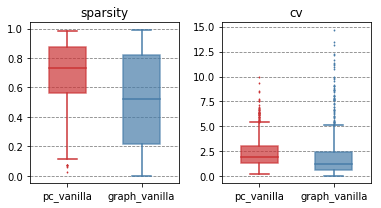

In [14]:
methods = ["smFISH", 
           "graph_vanilla_lam_init", 
           "pc_vanilla_lam_init", 
           "graph_vanilla_lam_update", 
           "pc_vanilla_lam_update",
           "unsup_graph",
           "unsup_pc"]


cmp_methods = {key: pipe_res[key] for key in ["pc_vanilla", "graph_vanilla"]}
pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(cmp_methods)
pval_df = pd.concat([var_df.reset_index(drop=True), pval_df], axis=1)
pval_df.head()
lm_genes = get_known_liver_markers()["zonation"]
report_genes = ["Hamp", "Hamp2", "Igfbp2", "Mup3", "Cyp8b1"]
unique_dict, unique_df = get_unique_rejection_df(cmp_methods, var_df)
unique_glist = {}
top_k = 10
for key in cmp_methods:
    unique_glist[key] = list(unique_dict[key].index[:top_k])
    display(unique_dict[key].head(top_k))
display(unique_df.head())

# plot box plots
var_df["cv"] = var_df["std"] / var_df["mean"]
var_df["sparsity"] = 1 - (var_df["n_cells"]/ x_d.shape[0])
display(var_df.head())
plot_contrast_rejections(cmp_methods, var_df)
